In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
from cupyx.scipy.sparse import csr_matrix 
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
import pickle
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist

In [2]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Breast_Cancer/age_76/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_3"

In [3]:
def parquet_to_csv(path):
    '''
    Converts a Parquet file to a CSV file if the CSV file does not already exist.
    '''
    file_path = os.path.join(path,'spatial/tissue_positions_list.csv')
    if not os.path.exists(file_path):
        df = pd.read_parquet(os.path.join(path,'spatial/tissue_positions.parquet'))
        # Write to a CSV file
        df.to_csv(os.path.join(path,'spatial/tissue_positions_list.csv'), index=False)
    return
parquet_to_csv(path_016)

In [4]:
andata = sc.read_visium(path=path_016,load_images=False)
df = pd.read_parquet(os.path.join(path_016,'spatial/tissue_positions.parquet'))


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
andata.obsm['spatial'] = df.loc[df.in_tissue.values==1,['pxl_row_in_fullres','pxl_col_in_fullres']].to_numpy()

In [6]:
rsc.get.anndata_to_GPU(andata)
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.var_names_make_unique()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="MT-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])

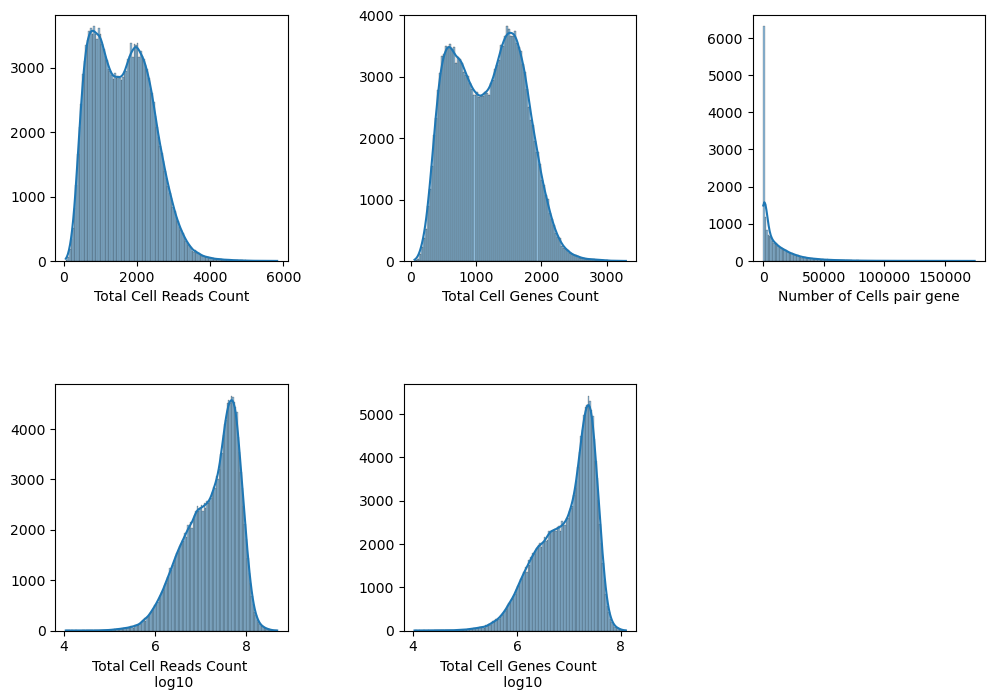

In [7]:
import warnings
# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    ax[5].axis('off')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

In [8]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig, ax = plt.subplots(1,1, figsize=(15, 15))
with PdfPages(os.path.join(pathout, 'Report_spatial_map_plot_BreastCancer_total_count.pdf')) as pdf:
    plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax ,set_xlabel_cbar = 'Total Count',size = 1)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()   

In [9]:
rsc.pp.filter_cells(andata, min_count=50,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=50)
rsc.pp.filter_genes(andata, max_count=50_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=5000, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

filtered out 0 cells
filtered out 717 genes based on n_cells_by_counts
filtered out 689 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


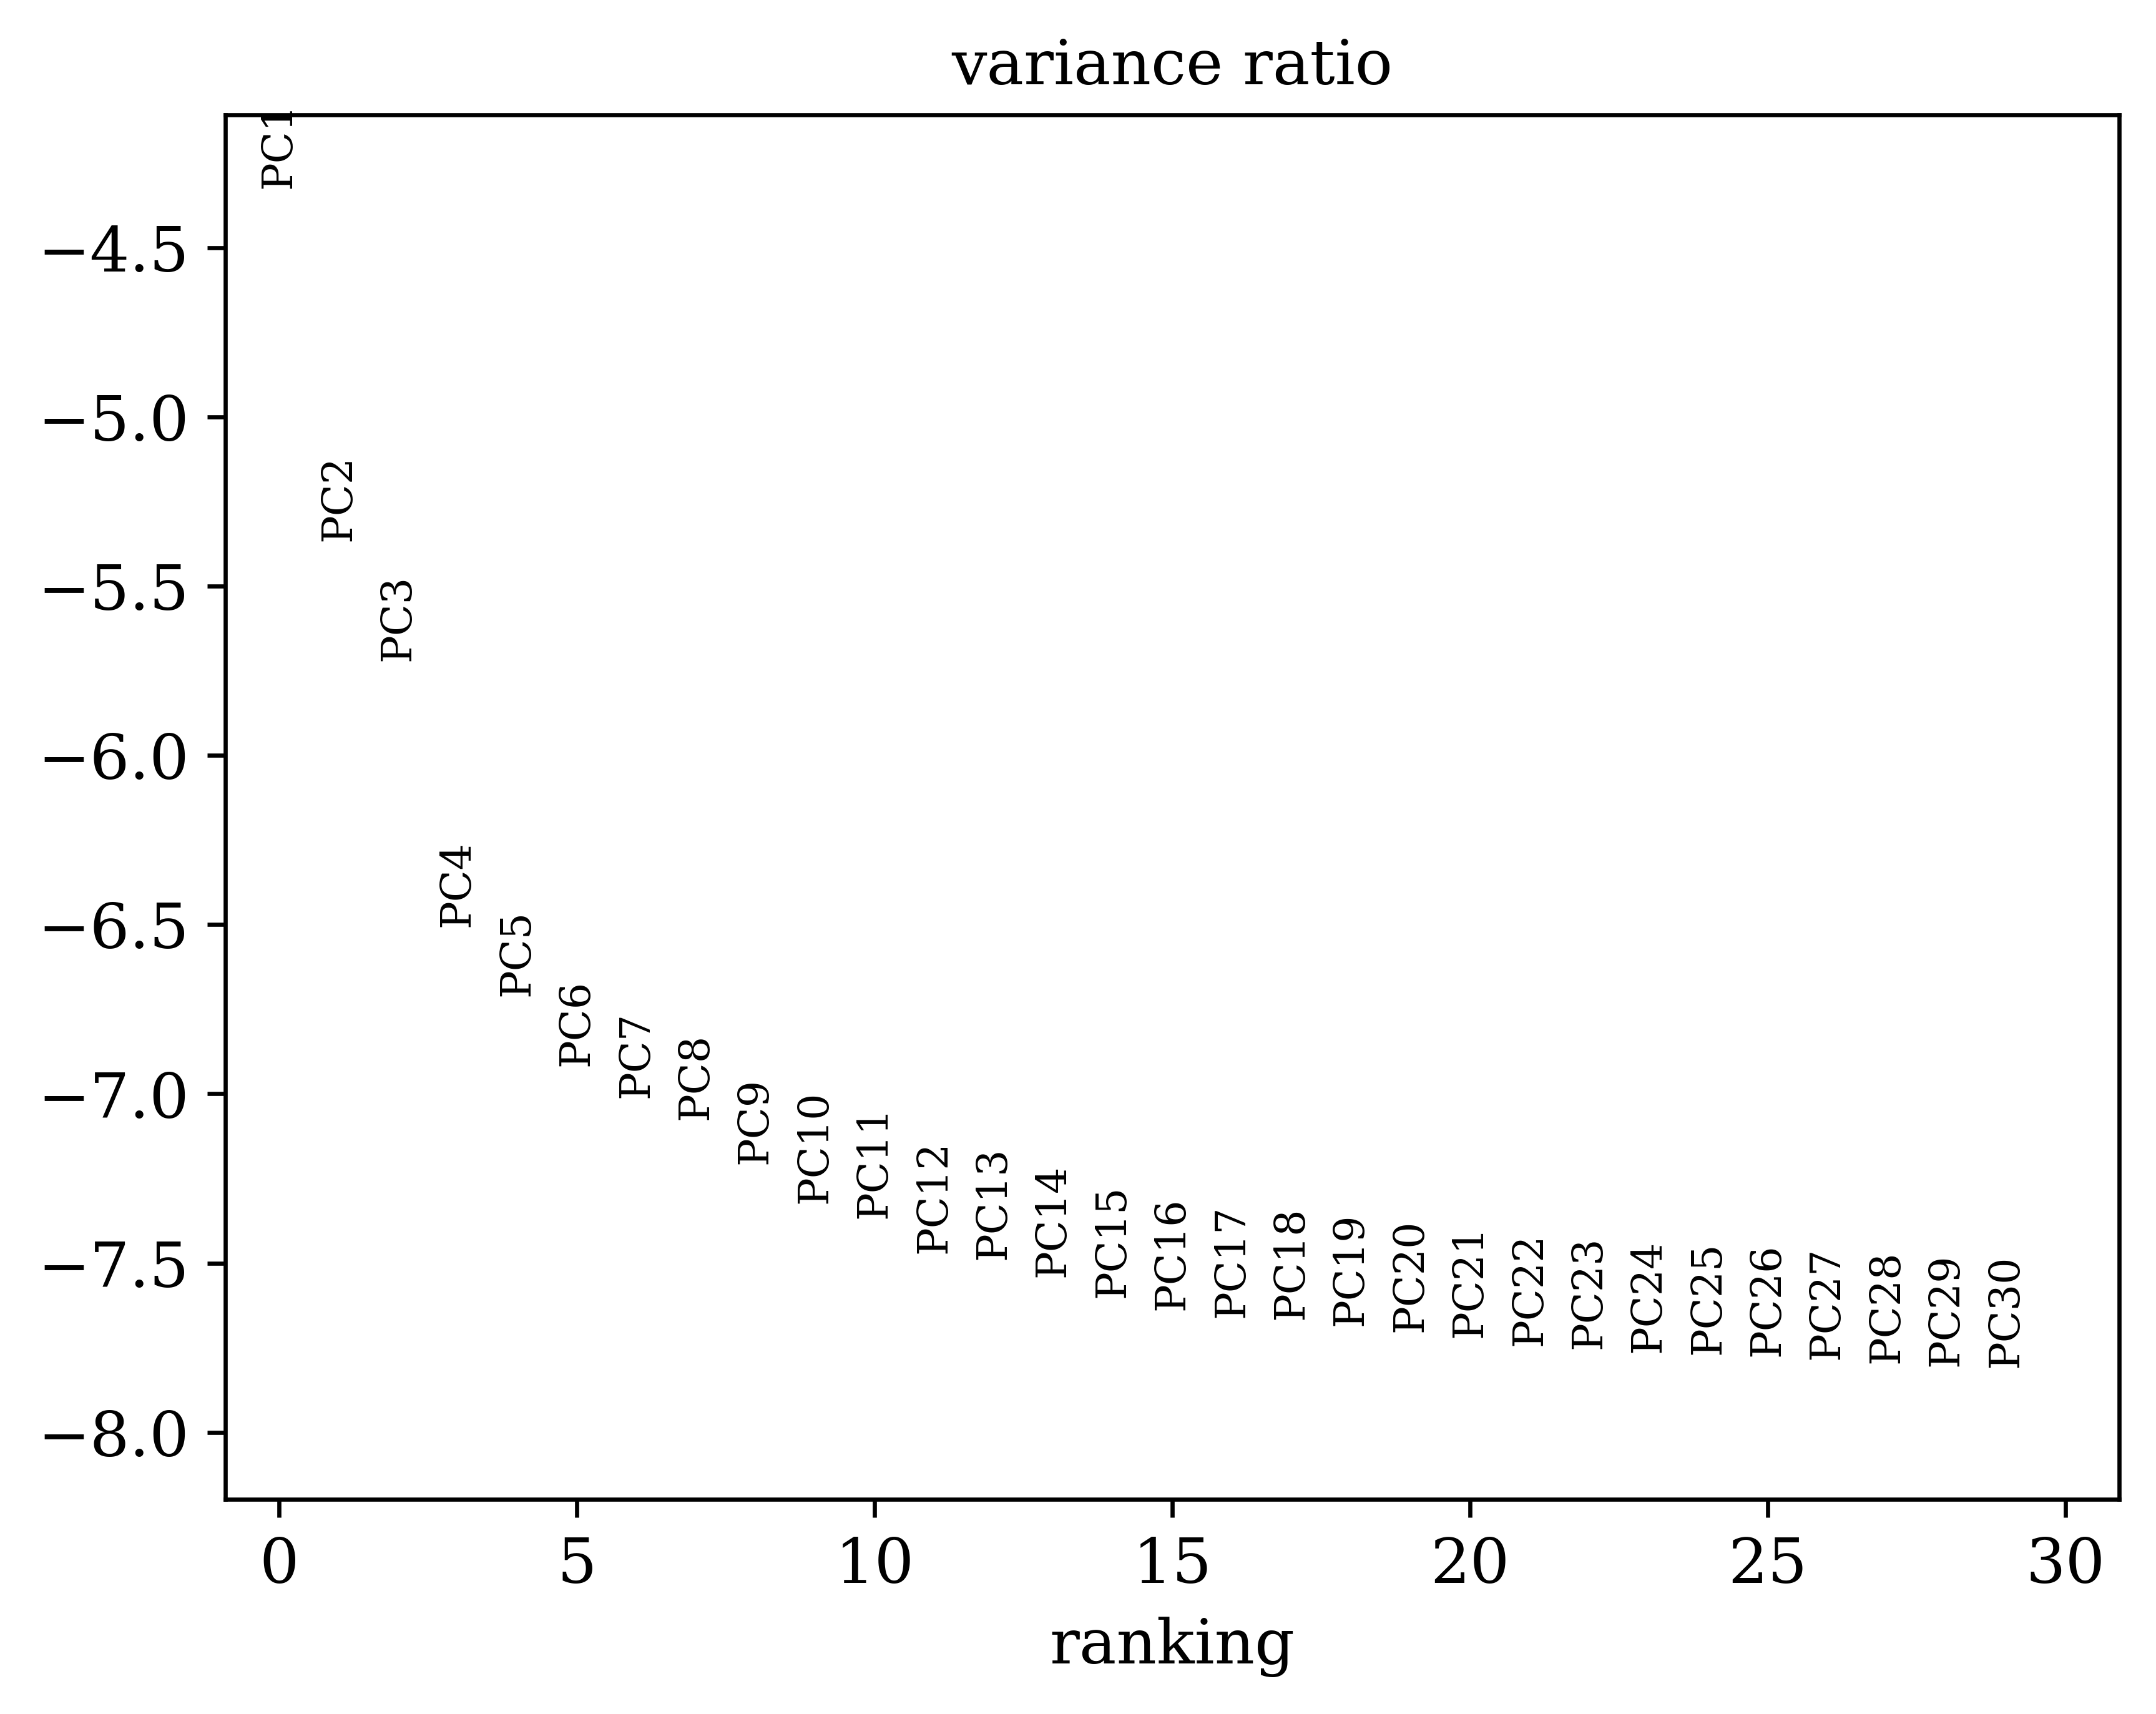

In [11]:
sc.pl.pca_variance_ratio(andata, log=True, n_pcs=30)

In [14]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=25)

In [15]:
resolutions = [0.5,0.8,1,2]
for res in resolutions:
    rsc.tl.leiden(andata, random_state=1337, resolution=res, key_added='cluster')
    with PdfPages(os.path.join(pathout, f'Report_spatial_map_plot_BrestCancer_{res}.pdf')) as pdf:
        fig, ax = plt.subplots(1, 1, figsize=(15,15))
        plt.rcParams['figure.dpi'] = 600
        plt.rcParams['font.family'] = ['serif']
        plt.rcParams['font.size'] = 12
        plt.rcParams['axes.labelsize'] = 12
        plt.rcParams['axes.titlesize'] = 12
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        clusterColorMap = plot_spatial(andata,ax = ax, features = None, title = f'resolution: {res}',markerscale = 5, xlab = '',ylab ='',size = 0.1)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
        pdf.savefig()
        plt.close()
    print(f'{res}')

0.5
0.8
1
2
